# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [249]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import math

### Set all the Constants

In [368]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=4
n_classes = 4
MODEL_DIR_NAME = "Sugarcane"

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [369]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    MODEL_DIR_NAME,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 224 files belonging to 3 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [370]:
class_names = dataset.class_names
n_classes = len(class_names)
class_names

['Healthy', 'RedRot', 'RedRust']

In [371]:

n_classes

3

In [372]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[2 2 2 1 2 0 0 0 2 0 2 1 1 0 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

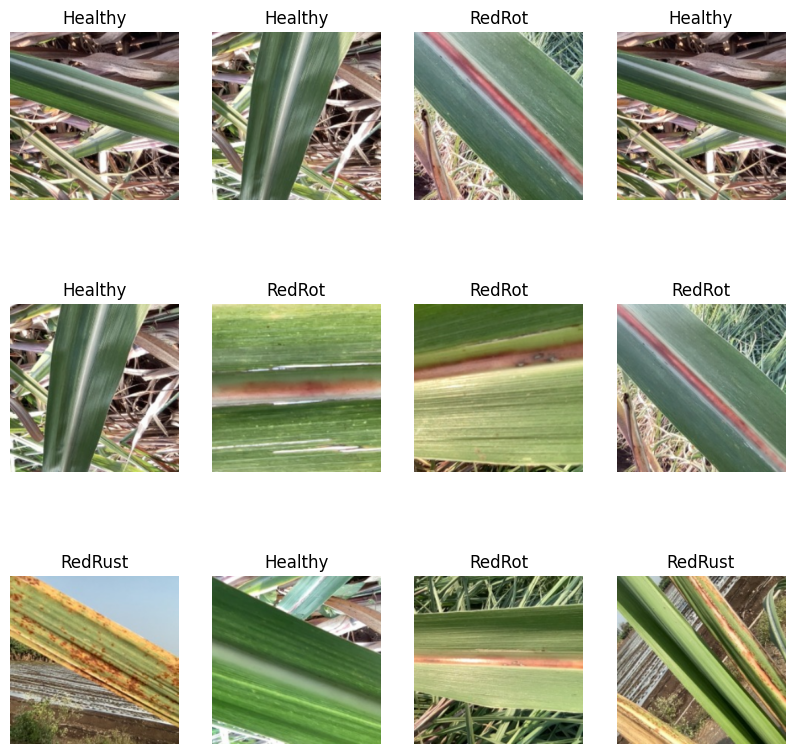

In [373]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [374]:
len(dataset)

14

In [375]:
train_size = 0.80
val_size = 0.10
test_size = 0.10

In [376]:

TRAIN_BATCH = math.floor(len(dataset)*train_size)
len(dataset)*train_size

11.200000000000001

In [377]:
train_ds = dataset.take(TRAIN_BATCH)
len(train_ds)


11

In [378]:
test_ds = dataset.skip(len(train_ds))
len(test_ds)

3

In [379]:

VALIDATION_BATCH = math.floor(len(dataset)*val_size)
#VALIDATION_BATCH =1
len(dataset)*val_size

1.4000000000000001

In [380]:
val_ds = test_ds.take(VALIDATION_BATCH)
len(val_ds)

1

In [381]:
test_ds = test_ds.skip(len(val_ds))
len(test_ds)

2

In [382]:
def get_dataset_partitions_tf(ds, train_split=train_size, val_split=val_size, test_split=test_size, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [383]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [384]:
len(train_ds)

11

In [385]:
len(val_ds)

1

In [386]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [387]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [388]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [389]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [390]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [391]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
#n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [392]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (16, 256, 256, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPooli  (16, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (16, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (16, 60, 60, 64)        

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [393]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [394]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
11/11 [==============================] - 13s 999ms/step - loss: 1.1099 - accuracy: 0.3125 - val_loss: 1.0899 - val_accuracy: 0.3750
Epoch 2/10
11/11 [==============================] - 11s 955ms/step - loss: 1.0965 - accuracy: 0.3580 - val_loss: 1.0958 - val_accuracy: 0.3750
Epoch 3/10
11/11 [==============================] - 10s 942ms/step - loss: 1.0943 - accuracy: 0.3580 - val_loss: 1.0821 - val_accuracy: 0.3750
Epoch 4/10
11/11 [==============================] - 11s 956ms/step - loss: 1.0818 - accuracy: 0.3636 - val_loss: 0.9843 - val_accuracy: 0.3750
Epoch 5/10
11/11 [==============================] - 11s 980ms/step - loss: 0.9857 - accuracy: 0.4773 - val_loss: 0.8482 - val_accuracy: 0.5000
Epoch 6/10
11/11 [==============================] - 11s 1s/step - loss: 0.7193 - accuracy: 0.6648 - val_loss: 0.6229 - val_accuracy: 0.6250
Epoch 7/10
11/11 [==============================] - 11s 1s/step - loss: 0.6956 - accuracy: 0.7045 - val_loss: 0.4051 - val_accuracy: 0.8125
Epoch

In [395]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 247ms/step - loss: 0.4323 - accuracy: 0.8438


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [396]:
scores

[0.43227776885032654, 0.84375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [397]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [398]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 11}

In [399]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [400]:
type(history.history['loss'])

list

In [401]:
len(history.history['loss'])

10

In [402]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1099084615707397,
 1.0965399742126465,
 1.0943373441696167,
 1.0818219184875488,
 0.9857043623924255]

In [403]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

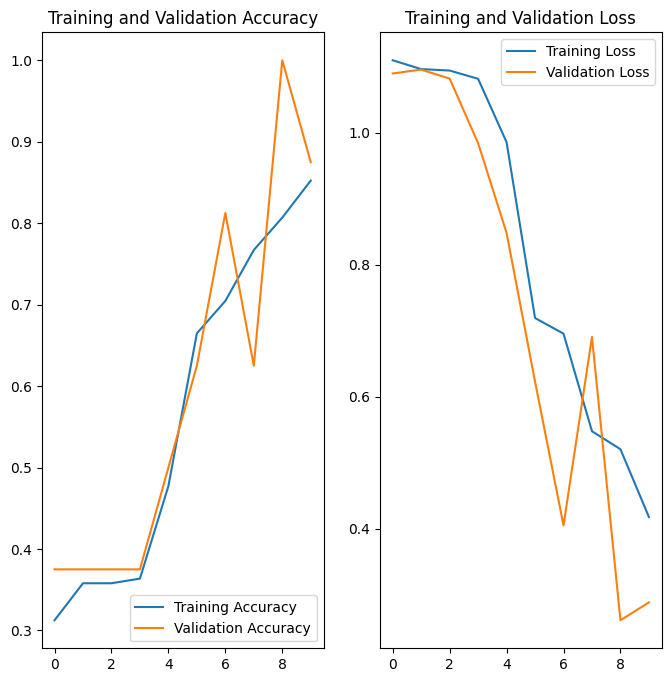

In [405]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 401ms/step
predicted label: Healthy


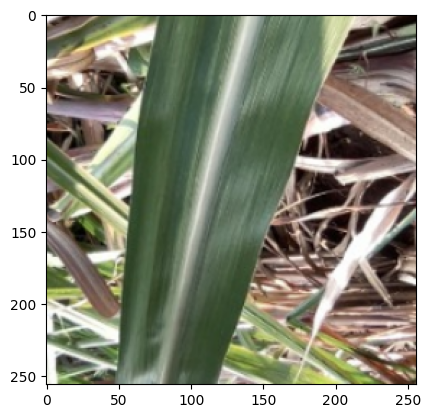

In [406]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [407]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 53ms/step


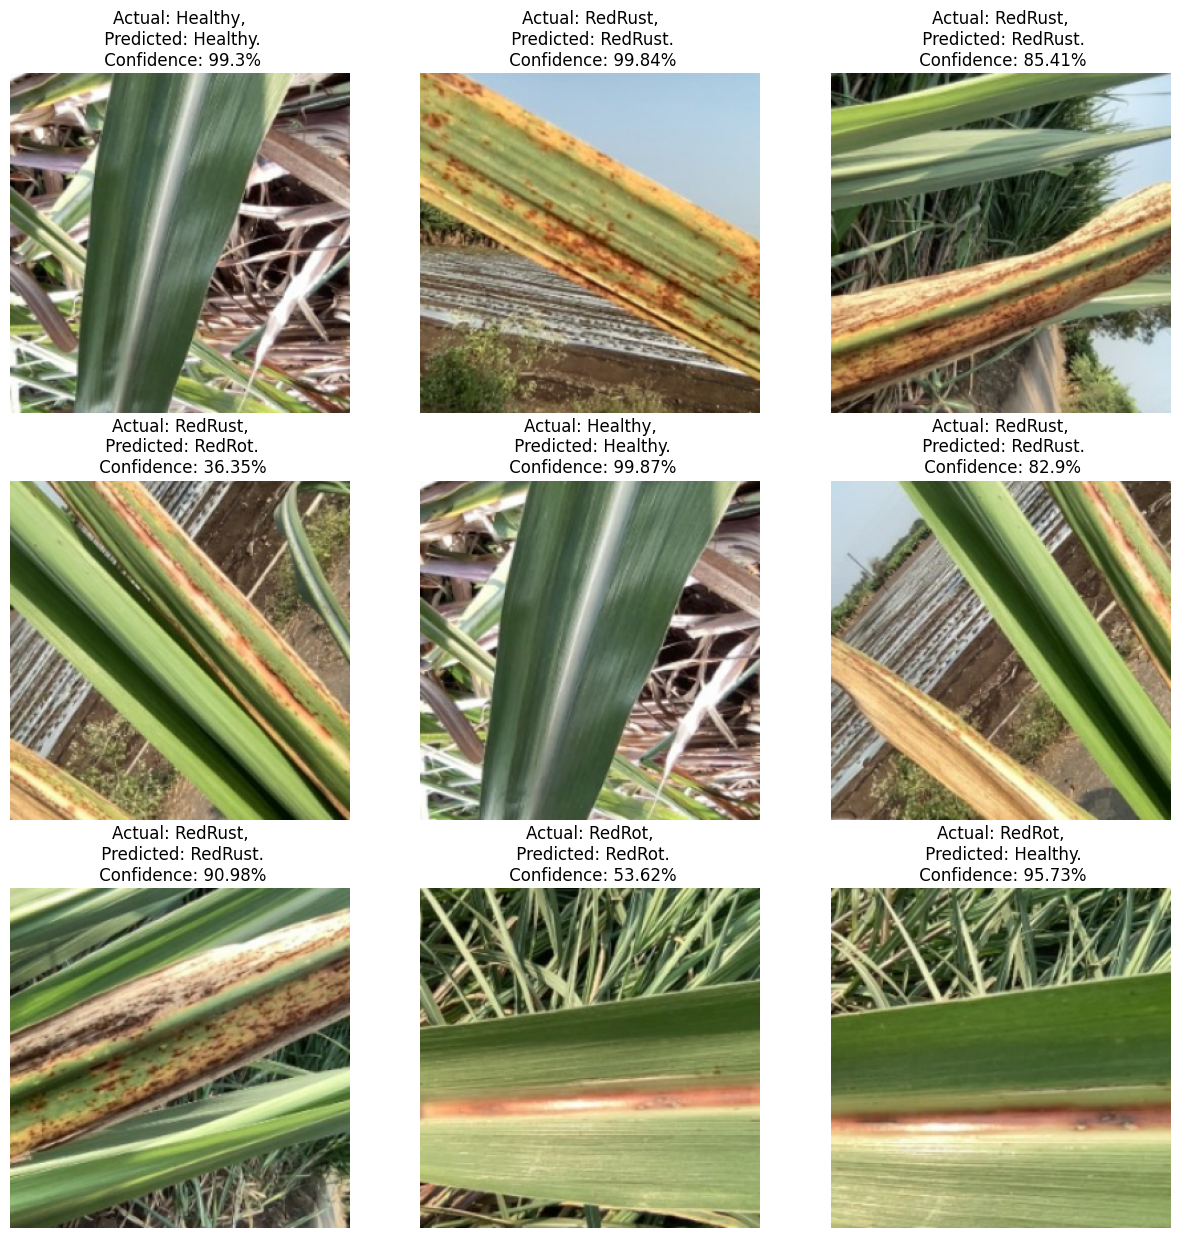

In [408]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [409]:
import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model_version=1

model.save(f"../models/{MODEL_DIR_NAME}_v{model_version}")

INFO:tensorflow:Assets written to: ../models/Sugarcane_v1\assets


INFO:tensorflow:Assets written to: ../models/Sugarcane_v1\assets


In [410]:
model.save(f"../{MODEL_DIR_NAME}.h5")

C:\Users\zeon-X\miniconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
